# 📈 Cluster Financial Analysis & GGR Trends

## Executive Summary
This notebook connects the behavioral segments defined in the previous step (Whales, Grinders, etc.) with raw financial transaction logs. 

**Objectives:**
1.  **GGR Analysis**: Track Gross Gaming Revenue (Net Loss) over time per cluster.
2.  **Wallet Share**: Analyze the distribution of transaction sizes per segment.
3.  **Profitability**: Compare Average Revenue Per User (ARPU) across segments.

**Data Sources:**
* `casino_ctg.log_db.players_clustered`: Player Labels (Source)
* `casino_ctg.log_db.transactions_bronze`: Raw Transaction Logs

In [0]:
#python imports_and_config magic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, date_trunc, sum as _sum, avg, count, abs

# Set Seaborn Theme for beautiful plots
sns.set_theme(style="whitegrid", context="talk")
sns.set_palette("Spectral") # A nice diverging palette

# Databricks Display Helper
def show_plot():
    plt.show()

## 1. Data Loading & Joining
We join the `transactions` table with our `players_clustered` table to tag every single financial event with a Persona Label.

In [0]:
# 1. Load Tables
df_clusters = spark.table("casino_ctg.log_db.players_clustered")
df_trans = spark.table("casino_ctg.log_db.transactions_bronze")

# 2. Join
# We use an Inner Join to focus only on players we have successfully segmented
df_joined = df_trans.join(df_clusters, on="player_id", how="inner")

# 3. Quick Validation
print(f"Joined Data Count: {df_joined.count():,}")
display(df_joined.limit(5))

Joined Data Count: 16,847,373


player_id,transaction_id,game_id,timestamp,bet_amount,win_amount,net_result,session_id,session_balance,consecutive_losses,consecutive_wins,hour,day_of_week,day_of_month,month,is_weekend,is_peak_hour,is_payday,date,cluster,label
P000002,S00092153_0000,G002,2024-08-02T21:23:00.000Z,469.22,703.83,234.61,S00092153,234.61,0,1,21,4,2,8,0,1,0,2024-08-02T00:00:00.000Z,2,🎲 Risk Taker
P000002,S00092153_0001,G002,2024-08-02T21:23:10.404Z,469.22,469.22,0.0,S00092153,234.61,0,2,21,4,2,8,0,1,0,2024-08-02T00:00:00.000Z,2,🎲 Risk Taker
P000002,S00092153_0002,G002,2024-08-02T21:23:43.478Z,516.14,0.0,-516.14,S00092153,-281.53,1,0,21,4,2,8,0,1,0,2024-08-02T00:00:00.000Z,2,🎲 Risk Taker
P000002,S00092153_0003,G002,2024-08-02T21:24:29.768Z,516.14,0.0,-516.14,S00092153,-797.67,2,0,21,4,2,8,0,1,0,2024-08-02T00:00:00.000Z,2,🎲 Risk Taker
P000002,S00092153_0004,G002,2024-08-02T21:24:54.254Z,516.14,516.14,0.0,S00092153,-797.67,0,1,21,4,2,8,0,1,0,2024-08-02T00:00:00.000Z,2,🎲 Risk Taker


## 2. Trend Analysis: GGR Over Time
We aggregate the data by `Month` and `Label` to see how revenue is trending for each segment. 

*Note: We assume 'amount' is negative for player bets/losses. We multiply by -1 to get positive GGR.*

/home/spark-3626c2dc-4f7a-4ea5-bf23-54/.ipykernel/2723/command-6466786311727367-3392608837:38: UserWarning: Glyph 127958 (\N{BEACH WITH UMBRELLA}) missing from current font.
  plt.tight_layout()
/home/spark-3626c2dc-4f7a-4ea5-bf23-54/.ipykernel/2723/command-6466786311727367-3392608837:38: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  plt.tight_layout()
/home/spark-3626c2dc-4f7a-4ea5-bf23-54/.ipykernel/2723/command-6466786311727367-3392608837:38: UserWarning: Glyph 127922 (\N{GAME DIE}) missing from current font.
  plt.tight_layout()
/home/spark-3626c2dc-4f7a-4ea5-bf23-54/.ipykernel/2723/command-6466786311727367-3392608837:38: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from current font.
  plt.tight_layout()
/databricks/python/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127958 (\N{BEACH WITH UMBRELLA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/databricks/python/lib/python3

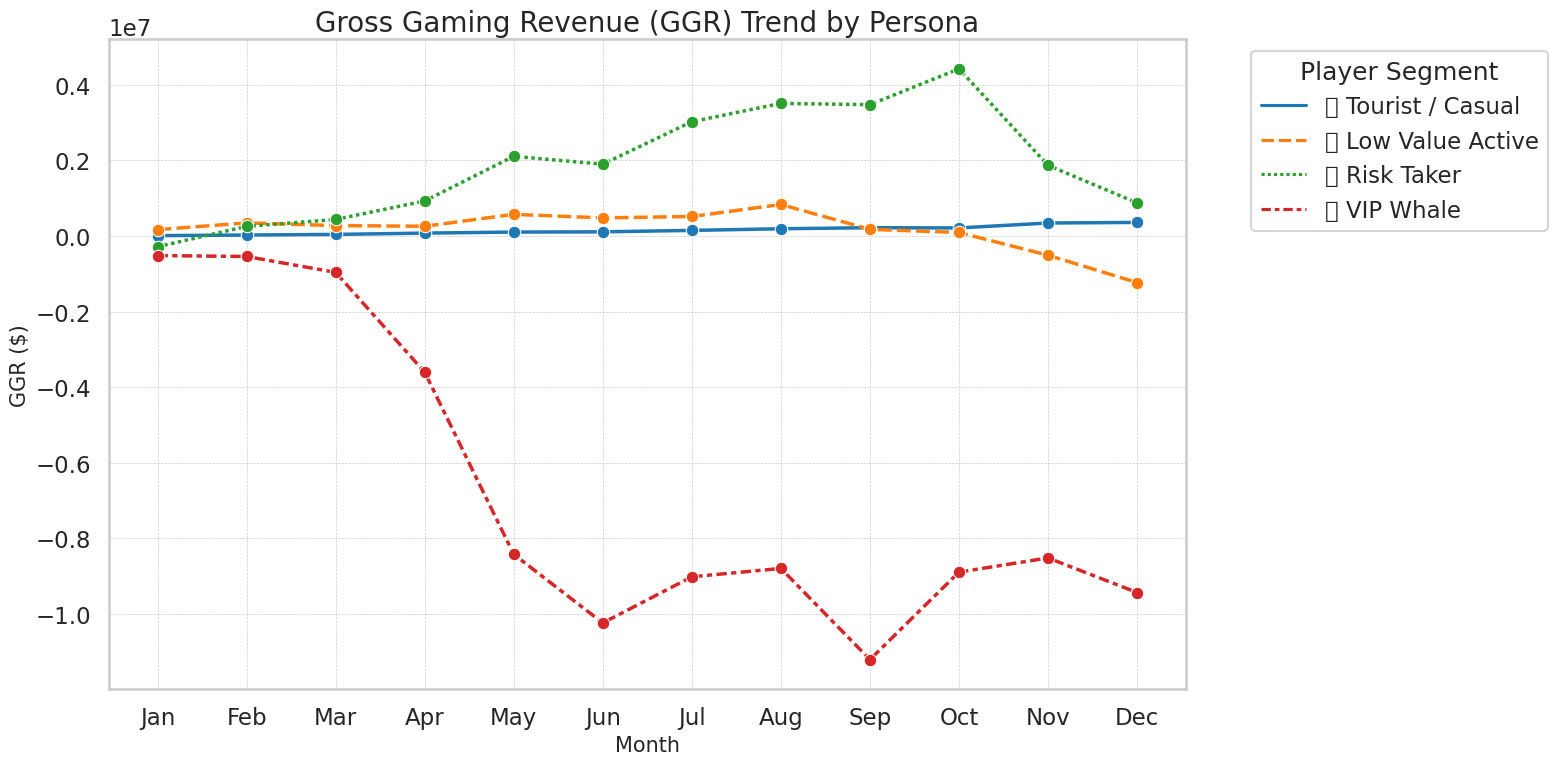

In [0]:
from pyspark.sql.functions import col, to_date, date_format, sum, count

# 1. Spark Aggregation (Heavy Lifting)
monthly_ggr_spark = (df_joined
    # Create helper for sorting and abbreviation for display
    .withColumn("date_helper", to_date(col("month"), "M"))
    .withColumn("month_abbr", date_format(col("date_helper"), "MMM"))
    
    # Group by the ABBREVIATION, but keep date_helper for sorting
    .groupBy(
        "label", 
        "month_abbr",
        "date_helper" 
    )
    .agg(
        (sum("net_result") * -1).alias("GGR"),
        count("transaction_id").alias("tx_volume")
    )
    
    # Order by the date object (Chronological), then remove it
    .orderBy("date_helper")
    .drop("date_helper")
)

# 2. Convert to Pandas for Plotting
ggr_trend = monthly_ggr_spark.toPandas()

# 3. Visualization
plt.figure(figsize=(16, 8))
sns.lineplot(data=ggr_trend, x="month_abbr", y="GGR", hue="label", 
             linewidth=2.5, marker='o', style="label",palette="tab10")

plt.title("Gross Gaming Revenue (GGR) Trend by Persona", fontsize=20)
plt.ylabel("GGR ($)", fontsize=15)
plt.xlabel("Month", fontsize=15)
plt.legend(title="Player Segment", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
show_plot()

## 3. Profitability: Average Revenue Per User (ARPU)
Which segment is actually the most valuable on a per-capita basis?

/home/spark-3626c2dc-4f7a-4ea5-bf23-54/.ipykernel/2723/command-6466786311727369-2421568695:45: UserWarning: Glyph 127922 (\N{GAME DIE}) missing from current font.
  plt.tight_layout()
/home/spark-3626c2dc-4f7a-4ea5-bf23-54/.ipykernel/2723/command-6466786311727369-2421568695:45: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  plt.tight_layout()
/home/spark-3626c2dc-4f7a-4ea5-bf23-54/.ipykernel/2723/command-6466786311727369-2421568695:45: UserWarning: Glyph 127958 (\N{BEACH WITH UMBRELLA}) missing from current font.
  plt.tight_layout()
/home/spark-3626c2dc-4f7a-4ea5-bf23-54/.ipykernel/2723/command-6466786311727369-2421568695:45: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from current font.
  plt.tight_layout()
/databricks/python/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127922 (\N{GAME DIE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/databricks/python/lib/python3.11/site-pa

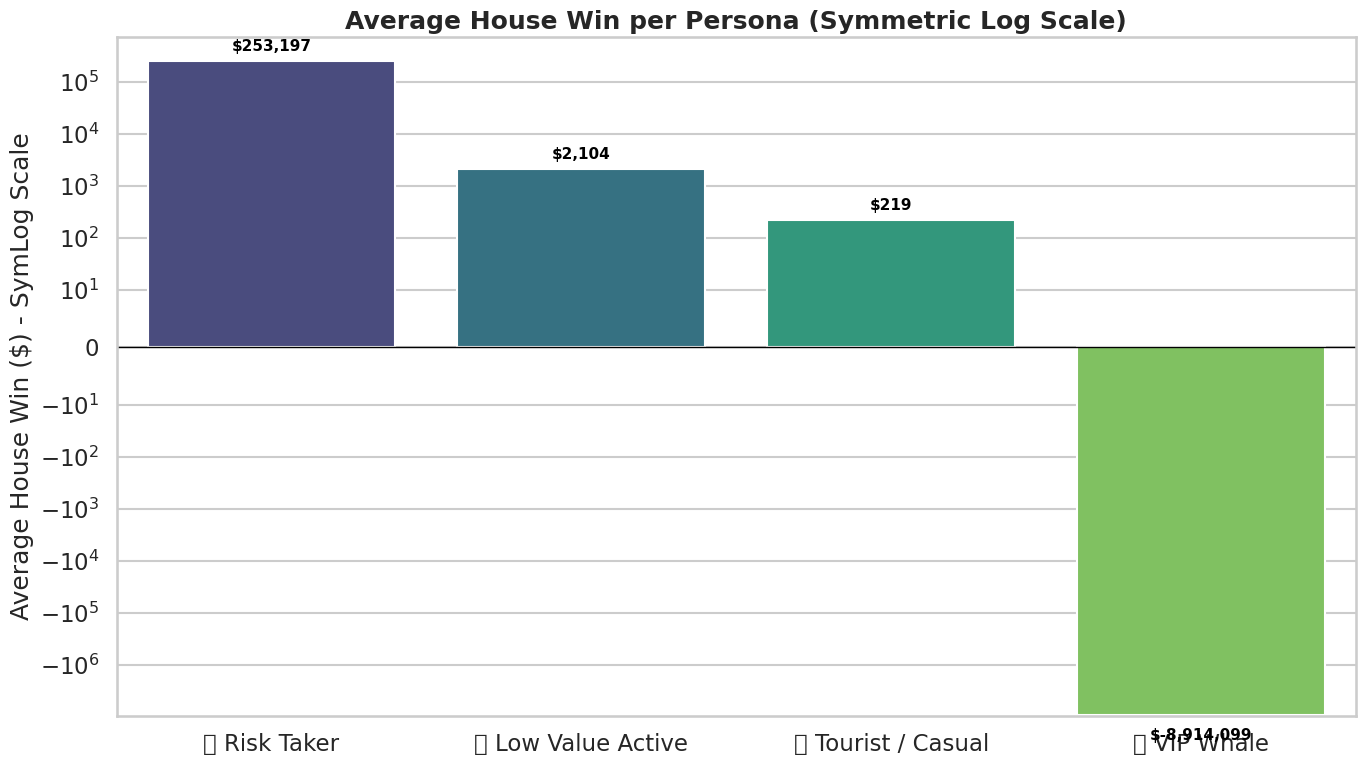

In [0]:
# 1. Aggregation: Calculate House Win (Negative Net Result = Positive House Win)
player_val_spark = df_joined.groupBy("player_id", "label").agg(
    (_sum("net_result") * -1).alias("house_win"), 
    count("transaction_id").alias("tx_count")
)

# 2. Aggregation: Average per Label
arpu_spark = player_val_spark.groupBy("label").agg(
    avg("house_win").alias("Avg_House_Win"),
    avg("tx_count").alias("Avg_Transactions")
).orderBy("Avg_House_Win", ascending=False)

arpu_df = arpu_spark.toPandas()

# 3. Visualization
plt.figure(figsize=(14, 8))
ax = sns.barplot(data=arpu_df, x="label", y="Avg_House_Win", palette="viridis")

# --- THE FIX: Symmetric Log Scale ---
# 'symlog' handles both massive positive AND massive negative numbers
# linthresh determines the range around 0 that remains linear (to avoid plot artifacts)
plt.yscale('symlog', linthresh=10) 

# --- Annotations (Adjusted for Positive/Negative bars) ---
for p in ax.patches:
    height = p.get_height()
    # If bar is negative (House Loss), put label below. If positive, put above.
    va_align = 'top' if height < 0 else 'bottom'
    xy_offset = (0, -10) if height < 0 else (0, 5)
    
    ax.annotate(f'${height:,.0f}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va=va_align, 
                fontsize=11, fontweight='bold', color='black',
                xytext=xy_offset, textcoords='offset points')

# Updated Titles/Labels as requested
plt.title("Average House Win per Persona (Symmetric Log Scale)", fontsize=18, fontweight='bold')
plt.ylabel("Average House Win ($) - SymLog Scale")
plt.xlabel("")

# Add a reference line at 0 to clearly separate House Wins from House Losses
plt.axhline(0, color='black', linewidth=1)
plt.xticks(rotation=0)
plt.tight_layout()
show_plot()

## 4. Volatility Analysis: Bet Sizing Distribution
Do "Whales" consistently bet big, or do they have high variance? We use a Box Plot to show the spread of transaction amounts.

/databricks/python/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127922 (\N{GAME DIE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/databricks/python/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/databricks/python/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/databricks/python/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127958 (\N{BEACH WITH UMBRELLA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


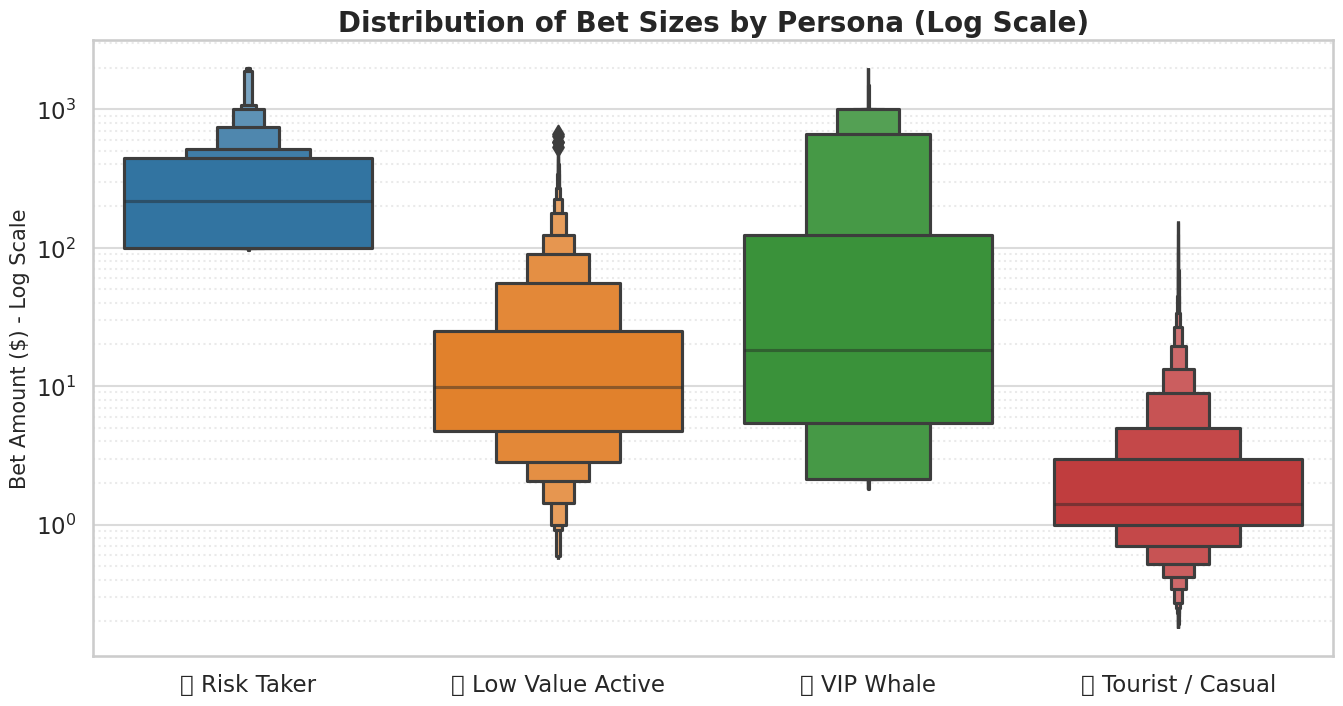

In [0]:
# 4. Volatility Analysis: Bet Sizing Distribution
# We filter > 0 to see actual risk appetite. 
# CRITICAL FIX: explicitly cast to 'double' here to handle decimal strings like '469.22'
sample_bets = df_joined.select(col("label"), col("bet_amount").cast("double")) \
                       .sample(fraction=0.1, seed=42) \
                       .toPandas()

plt.figure(figsize=(16, 8))

# Boxen plot shows the tails of the distribution better than a box plot
sns.boxenplot(data=sample_bets, x="label", y="bet_amount", palette="tab10")

# Log scale is mandatory for gambling data (ranges from $0.10 to $100k)
plt.yscale('log')

plt.title("Distribution of Bet Sizes by Persona (Log Scale)", fontsize=20, fontweight='bold')
plt.ylabel("Bet Amount ($) - Log Scale", fontsize=15)
plt.xlabel("", fontsize=15)

# Add minor gridlines to make log scale readable
plt.grid(True, which="minor", axis="y", linestyle=":", alpha=0.4)
plt.grid(True, which="major", axis="y", linestyle="-", alpha=0.7)

show_plot()